In [1]:
import matplotlib.pyplot as plt
import numpy as np
from model_based.train import make_train, HyperParams, EquiModel, Model, SARSDTuple
from model_based.sample_env import make_experience_fn, make_expert_experience_fn
import pickle
import jax
import jax.numpy as jnp
import base_rl.higher_order as ho
from base_rl.models import ActorCritic
import matplotlib

In [2]:
num = 2000
keys = jax.random.split(jax.random.PRNGKey(42), num)
random_data = jax.jit(jax.vmap(make_experience_fn("CartPole-v1", 500)))(keys)
random_data_len = np.prod(random_data.reward.shape)
random_data = jax.tree_map(lambda x: x.reshape((random_data_len, -1)), random_data)
# non_zero = (random_data.done == 0).reshape(-1)
# random_data = jax.tree_map(lambda x: x.at[non_zero, ...].get(), random_data )



/home/sean/ms_mono/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [3]:
hyp = HyperParams(model=Model, train_frac=0.8)
data = pickle.load(open("replay_buffer.pickle", "rb"))
print(jax.tree_map(lambda x: x.shape, data))
data_len = np.prod(data.reward.shape)
data = jax.tree_map(lambda x: x.reshape(data_len, -1), data)
perm = np.random.permutation(data_len)
data = jax.tree_map(lambda x: x.at[perm, ...].get(), data)

# non_zero = (data.done ==0).reshape(-1)
# data = jax.tree_map(lambda x: x.at[non_zero, ...].get(), data)



train_data, val_data = data.partition(hyp.get_train_size(data))
filtered_data = train_data.filter_by_action(0)

# jax.tree_map(lambda x: print(x.shape), train_data)
# jax.tree_map(lambda x: print(x.shape), val_data)

SARSDTuple(state=(2000, 500, 4), action=(2000, 500), reward=(2000, 500), next_state=(2000, 500, 4), done=(2000, 500))


In [4]:
def train_model(hyp, train_data, val_data):
    train = jax.jit(make_train(hyp, train_data, val_data))
    result = train(jax.random.PRNGKey(42))
    losses = result[1][0]
    return losses.train_loss.reshape(-1), losses.val_loss.reshape(-1), result[0] 
def get_x(loss, epoch):
    return np.linspace(0, epoch, len(loss))

In [5]:
EPCH=10
hyp = HyperParams(model=Model, train_frac=1, epochs=EPCH, learning_rate=1e-5)
hyp_equi = HyperParams(model=EquiModel, train_frac=1, epochs=EPCH, learning_rate=1e-5)
hyps = [ hyp, hyp_equi]
datas = [train_data, filtered_data, random_data]


In [6]:
moving_average = lambda x, w: np.convolve(x, np.ones(w), 'valid') / w
cs = ["blue", "indigo"]
sol =[]
models = {}
for hyp, c in zip(hyps, cs):
    sub_sol = []
    for i, data in enumerate(datas):
        train_loss, val_loss, runner_state= train_model(hyp, data, val_data)
        sub_sol.append((train_loss, val_loss))
        models[(hyp.model.__name__, i)] =runner_state 
        
    sol.append(sub_sol)

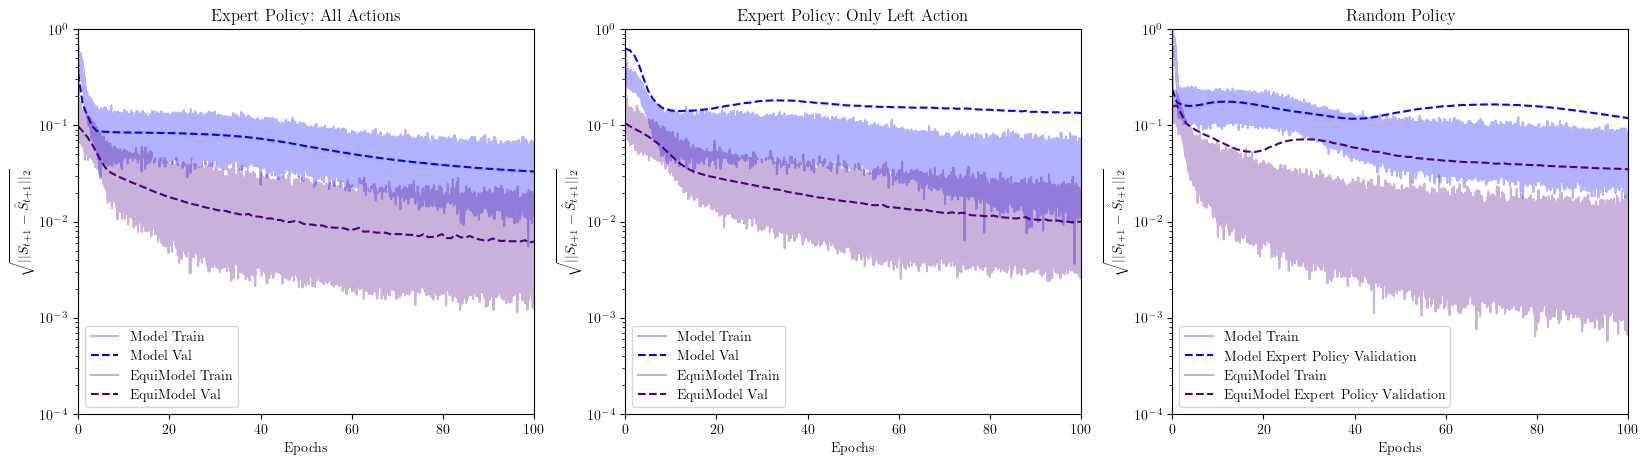

In [7]:
matplotlib.rcParams.update( {"text.usetex": True, "font.family": "serif",})
titles = ["Expert Policy: All Actions", "Expert Policy: Only Left Action", "Random Policy"]
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for sub_sol, hyp, c in zip(sol, hyps, cs):
    for i, ((train_loss, val_loss), tit) in enumerate(zip(sub_sol, titles)):
        trian_loss = moving_average(train_loss, 1000)
        ax[i].semilogy(get_x(train_loss, hyp.epochs),train_loss, label=f"{hyp.model.__name__} Train", color=c, alpha = 0.3)
        if tit == "Random Policy":
            ax[i].semilogy(get_x(val_loss, hyp.epochs), val_loss, label=f"{hyp.model.__name__} Expert Policy Validation", color=c, linestyle="--")
        else: 
            ax[i].semilogy(get_x(val_loss, hyp.epochs), val_loss, label=f"{hyp.model.__name__} Val", color=c, linestyle="--")
        ax[i].legend(loc="lower left")
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel("$\sqrt{||S_{t+1} - \hat{S}_{t+1}||_2}$")
        ax[i].set_title(tit)
        ax[i].set_xlim(0, EPCH)
        ax[i].set_ylim(1e-4, 1)



In [8]:
rng = jax.random.PRNGKey(42)
key = jax.random.split(rng, 500)
train = jax.jit(ho.make_train(ho.CONFIG, ActorCritic))

result = train(rng)
runner_state= result["runner_state"]


In [9]:
expert_train = jax.jit(jax.vmap((make_expert_experience_fn("CartPole-v1", 2000, runner_state[0].params))))

expert_data = expert_train(key)

In [10]:
def plot_by_angle(model_apply, model_params, data, bins:int=100):
    def _loss_fn(params, sarsd_tuple: SARSDTuple):
        state, action, _, next_state, _ = sarsd_tuple
        next_state_pred = model_apply(params, state, action)

        next_state_loss = np.mean((next_state - next_state_pred) ** 2, axis=0)

        return next_state_loss.mean() 
    
    data_len = np.prod(data.reward.shape)
    data = jax.tree_map(lambda x: x.reshape(data_len, -1), data)
    angels = data.state[..., 2]
    _, bins = jnp.histogram(angels, bins=100)
    bindex = [(angels >= bins[i]) & (angels < bins[i+1]) for i in range(len(bins)-1)]
    binned_data = [jax.tree_map(lambda x: x.at[ind].get(), data) for ind in bindex]
    losses = []
    for data in binned_data:
        loss = _loss_fn(model_params, data)
        losses.append(loss)
    return jnp.stack(losses), bins


    

In [11]:
losses, bins = [], []
for (m_name, i), runner_state in models.items():
    loss, bi= plot_by_angle(runner_state[1].apply_fn, runner_state[1].params, val_data)
    loss = np.nan_to_num(loss, 1)

    losses.append(loss)
    bins.append(bi)


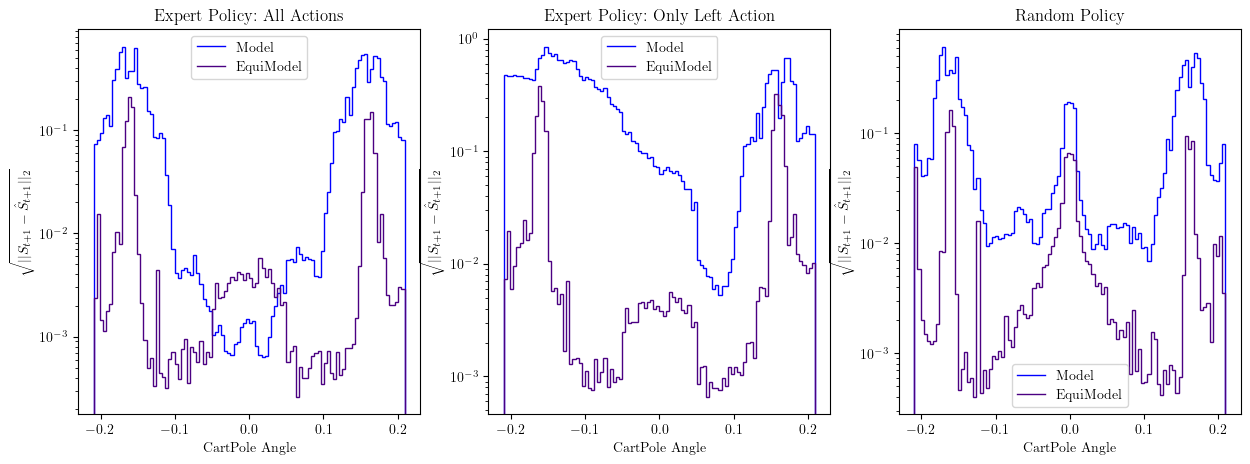

In [12]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for j,( (m_name, i), runner_state) in enumerate(models.items()):
    ax[i].stairs(losses[j], bins[j], label=m_name,color="blue" if m_name == "Model" else "indigo")
    ax[i].set_title(titles[i])
    ax[i].set_yscale("log")
    # ax[i].set_xlim(-.2, .2)
    # ax[i].set_ylim(1e-6, 1)
    ax[i].legend()
    ax[i].set_xlabel("CartPole Angle")
    ax[i].set_ylabel("$\sqrt{||S_{t+1} - \hat{S}_{t+1}||_2}$")
        